In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_selector
from sklearn.preprocessing import MinMaxScaler
from fancyimpute import KNN
from sklearn.impute import KNNImputer
from fancyimpute import IterativeImputer


In [16]:
data = pd.read_csv('../raw_data/dataset.csv',sep=';')
data = data.copy()
data.head()

,uuid,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,...,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,worst_status_active_inv
0,63f69b2c-8b1c-4740-b78d-52ed9a4515ac,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,...,1,1,1,1,0,0,0,178839,9.653333,1.0
1,0e961183-8c15-4470-9a5e-07a1bd207661,0.0,0,0.0,0.0,0.0,NaN,1.0,1.0,1.0,...,1,1,2,2,0,0,0,49014,13.181389,NaN
2,d8edaae6-4368-44e0-941e-8328f203e64e,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,1,1,2,2,0,0,0,124839,11.561944,1.0
3,0095dfb6-a886-4e2a-b056-15ef45fdb0ef,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,0,0,0,324676,15.751111,1.0
4,c8f8b835-5647-4506-bf15-49105d8af30b,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,0,1,1,1,0,0,0,7100,12.698611,NaN


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99976 entries, 0 to 99975
Data columns (total 43 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   uuid                                 99976 non-null  object 
 1   default                              89976 non-null  float64
 2   account_amount_added_12_24m          99976 non-null  int64  
 3   account_days_in_dc_12_24m            88140 non-null  float64
 4   account_days_in_rem_12_24m           88140 non-null  float64
 5   account_days_in_term_12_24m          88140 non-null  float64
 6   account_incoming_debt_vs_paid_0_24m  40661 non-null  float64
 7   account_status                       45603 non-null  float64
 8   account_worst_status_0_3m            45603 non-null  float64
 9   account_worst_status_12_24m          33215 non-null  float64
 10  account_worst_status_3_6m            42274 non-null  float64
 11  account_worst_status_6_12m  

## 1. Preprocessing workflow 

### 1.1. Duplicates

In [18]:
# Duplicates
duplicate_count = data.duplicated().sum()
duplicate_count

0

 ### 1.2. Missing values 

In [19]:
# Missing data percentage
round((data.isnull().sum()/len(data)).sort_values(ascending=False),2)

worst_status_active_inv                0.70
account_worst_status_12_24m            0.67
account_worst_status_6_12m             0.60
account_incoming_debt_vs_paid_0_24m    0.59
account_worst_status_3_6m              0.58
account_status                         0.54
account_worst_status_0_3m              0.54
avg_payment_span_0_3m                  0.49
avg_payment_span_0_12m                 0.24
num_active_div_by_paid_inv_0_12m       0.23
num_arch_written_off_12_24m            0.18
num_arch_written_off_0_12m             0.18
account_days_in_rem_12_24m             0.12
account_days_in_term_12_24m            0.12
account_days_in_dc_12_24m              0.12
default                                0.10
sum_paid_inv_0_12m                     0.00
sum_capital_paid_account_12_24m        0.00
sum_capital_paid_account_0_12m         0.00
recovery_debt                          0.00
status_max_archived_0_24_months        0.00
status_max_archived_0_6_months         0.00
status_3rd_last_archived_0_24m  

#### we do have a few features having a high percetange of missing values 
#### Let's investigate the meaning of these features and the besty way to deal with mising values

In [20]:
# unique values in this feature
data['worst_status_active_inv'].unique()

array([ 1., nan,  2.,  3.])

In [21]:
# account_worst_status_12_24m
data['account_worst_status_12_24m'].unique()

array([nan,  1.,  2.,  3.,  4.])

In [22]:
data['account_worst_status_12_24m'].isna().sum() / len(data['account_worst_status_12_24m'])

0.6677702648635673

In [42]:
_ = round((data.isnull().sum()/len(data)).sort_values(ascending=False),2)
miss_val_features_df = pd.DataFrame(_,columns=['percentage']).reset_index(names=['features'])
miss_val_features_df[miss_val_features_df['percentage'] >= 0.12]


,features,percentage
0,account_worst_status_12_24m,0.67
1,account_worst_status_6_12m,0.60
2,account_incoming_debt_vs_paid_0_24m,0.59
3,account_worst_status_3_6m,0.58
4,account_status,0.54
5,account_worst_status_0_3m,0.54
6,avg_payment_span_0_3m,0.49
7,avg_payment_span_0_12m,0.24
8,num_active_div_by_paid_inv_0_12m,0.23
9,num_arch_written_off_0_12m,0.18


In [24]:
# let's drop this worst_status_active_inv feature it has a too high missing values 
del data['worst_status_active_inv']


## Steps to Predicting the Missing data 

In [25]:
# necessary to covert to float
data_id = data['uuid']
_ = data.reset_index()
data = _.drop(['uuid'], axis=1)

### K-Nearest Neighbor 


In [26]:
data_obj_bool = pd.DataFrame()
data_obj_bool[['merchant_category ','merchant_group','has_paid ','name_in_email']] = data.select_dtypes(include=['object', 'bool'])

In [27]:
data.drop(columns=['merchant_category','merchant_group','has_paid','name_in_email'], inplace=True)

In [36]:
target = data['default']
data.drop(columns = ['default'], inplace=True)

In [40]:
# instatiate the model
imputer = KNNImputer(n_neighbors=2)
# imputing the missing value with knn imputer by fitting
data_clean = imputer.fit_transform(data)

In [43]:
data_clean

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.78839000e+05, 9.65333333e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 4.90140000e+04, 1.31813889e+01],
       [2.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.24839000e+05, 1.15619444e+01],
       ...,
       [9.99730000e+04, 4.56710000e+04, 0.00000000e+00, ...,
        1.96270000e+04, 3.10000000e+03, 2.18527778e+00],
       [9.99740000e+04, 5.61020000e+04, 0.00000000e+00, ...,
        5.61800000e+04, 3.47850000e+04, 9.72527778e+00],
       [9.99750000e+04, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 3.06020000e+04, 1.15852778e+01]])

In [44]:
data_clean_df = pd.DataFrame(data_clean,columns=data.columns)

In [46]:
del data_clean_df['index']

In [47]:
# Combine DataFrame objects horizontally along the x axis by passing in axis=1
data_clean_df = pd.concat([data_clean_df,data_obj_bool,data_id,target], axis=1)
data_clean_df = data_clean_df.set_index('uuid')

In [48]:
data_clean_df.head()

,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,account_worst_status_3_6m,account_worst_status_6_12m,...,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,merchant_category,merchant_group,has_paid,name_in_email,default
uuid,,,,,,,,,,,,,,,,,,,,,
63f69b2c-8b1c-4740-b78d-52ed9a4515ac,0.0,0.0,0.0,0.0,0.000000,1.0,1.0,1.5,1.0,1.0,...,0.0,0.0,0.0,178839.0,9.653333,Dietary supplements,Health & Beauty,True,no_match,0.0
0e961183-8c15-4470-9a5e-07a1bd207661,0.0,0.0,0.0,0.0,0.036851,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,49014.0,13.181389,Books & Magazines,Entertainment,True,F+L,0.0
d8edaae6-4368-44e0-941e-8328f203e64e,0.0,0.0,0.0,0.0,0.000079,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,124839.0,11.561944,Diversified entertainment,Entertainment,True,L1+F,0.0
0095dfb6-a886-4e2a-b056-15ef45fdb0ef,0.0,0.0,0.0,0.0,1.184280,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,324676.0,15.751111,Diversified entertainment,Entertainment,True,F1+L,0.0
c8f8b835-5647-4506-bf15-49105d8af30b,0.0,0.0,0.0,0.0,0.000000,1.0,1.0,1.5,1.0,1.0,...,0.0,0.0,0.0,7100.0,12.698611,Electronic equipment & Related accessories,Electronics,True,F+L,0.0


In [ ]:
# I have to delete the rows with default nan from the data set 

In [ ]:
# saving the dataframe
data_clean_df.to_csv('../raw_data/data_clean.csv')

In [ ]:
# another way to fill the missing values 
# mice_imputer = IterativeImputer()
# filling the missing value with mice imputer
# _ = mice_imputer.fit_transform(data)



In [ ]:
# I have to select the object type of features 
# see slides and apply OneHotEncoder
cat_preprocessor = ColumnTransformer([
    ('num_encoder', MinMaxScaler(), make_column_selector(dtype_include="int64")),
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore', sparse=False), make_column_selector(dtype_include="object")),
    ('binary_encoder', OneHotEncoder(handle_unknown='ignore', sparse=False, drop="if_binary"), make_column_selector(dtype_include="bool"))
])
cat_preprocessor

ColumnTransformer(transformers=[('num_encoder', MinMaxScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x12e3bec10>),
                                ('cat_encoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x12e3be820>),
                                ('binary_encoder',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x12e3be430>)])

In [ ]:
# I have to remover the target - "default"
target = data_clean_df['default']
data_clean_df.drop(columns = ['default'], inplace=True)

KeyError: 'default'

### 1.3. Outliers detection

In [ ]:
# to get rid of the object and bool dtype variables from your dataframe
numerical_features = data_clean_df.select_dtypes(exclude=['object', 'bool'])
dict = {}
# identifying outliers with the 1.5 IQR RULE 
for col in numerical_features.columns: 
    percentile25 = numerical_features[col].quantile(0.25)
    percentile75 = numerical_features[col].quantile(0.75)
    IQR = percentile75 - percentile25 
    upper_limit = percentile25 + 1.5 * IQR
    lower_limit = percentile25 - 1.5 * IQR
    dict['upper_limit'+'_'+ col] = upper_limit 
    dict['lower_limit'+'_'+ col] = lower_limit
    

In [ ]:
# lets investigate these outliers
# Number of data in the range 
for col in numerical_features.columns:
    print('there are in total {} data in which {} are less than the lower limit.'.format(len(numerical_features[numerical_features[col] < dict['lower_limit_' + col]] ) , col))
    print('there are in total {} data in which {} are less than the upper limit.'.format(len(numerical_features[numerical_features[col] > dict['upper_limit_' + col]] ) , col))
    

there are in total 0 data in which account_amount_added_12_24m are less than the lower limit.
there are in total 22994 data in which account_amount_added_12_24m are less than the upper limit.
there are in total 0 data in which account_days_in_dc_12_24m are less than the lower limit.
there are in total 262 data in which account_days_in_dc_12_24m are less than the upper limit.
there are in total 0 data in which account_days_in_rem_12_24m are less than the lower limit.
there are in total 9668 data in which account_days_in_rem_12_24m are less than the upper limit.
there are in total 0 data in which account_days_in_term_12_24m are less than the lower limit.
there are in total 1216 data in which account_days_in_term_12_24m are less than the upper limit.
there are in total 0 data in which account_incoming_debt_vs_paid_0_24m are less than the lower limit.
there are in total 18207 data in which account_incoming_debt_vs_paid_0_24m are less than the upper limit.
there are in total 0 data in which

In [ ]:
warnings.filterwarnings("ignore")

outliers_feat = pd.DataFrame(columns = ['upper limit'])
for col in numerical_features.columns:
    if len(numerical_features[numerical_features[col] > dict['upper_limit_' + col]] ) > 1000:
        new_row = pd.DataFrame({'upper limit': [col]})
        outliers_feat = outliers_feat.append(new_row, ignore_index=True);
        
# note: I'm only considering the upper limit because we've a couple lo

In [ ]:
outliers_feat

,upper limit
0,account_amount_added_12_24m
1,account_days_in_rem_12_24m
2,account_days_in_term_12_24m
3,account_incoming_debt_vs_paid_0_24m
4,account_status
5,account_worst_status_0_3m
6,account_worst_status_12_24m
7,account_worst_status_3_6m
8,account_worst_status_6_12m
9,age


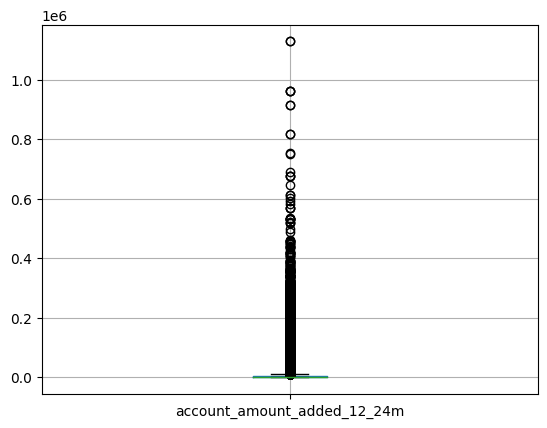

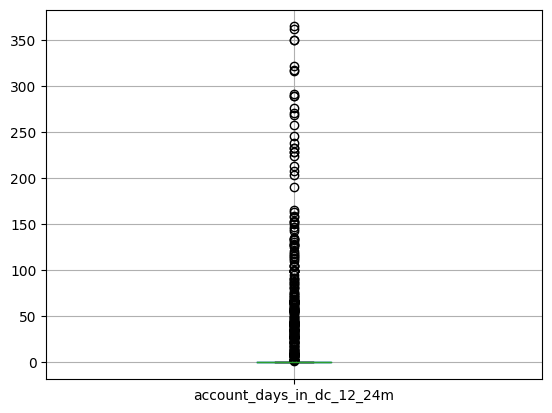

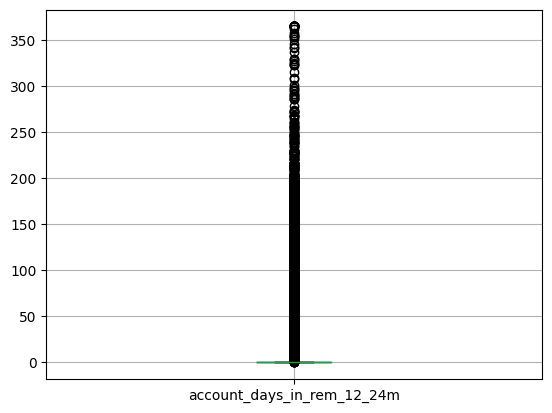

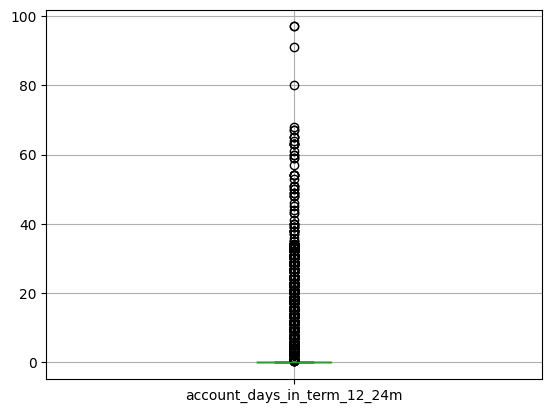

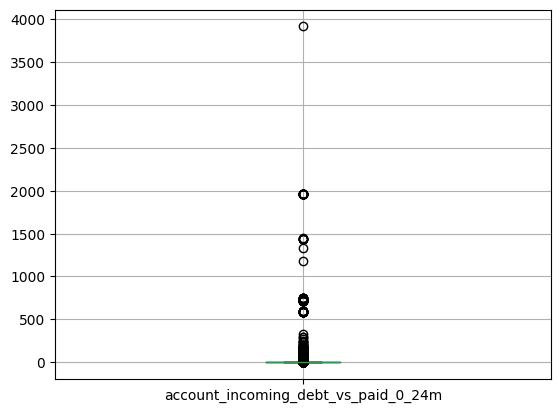

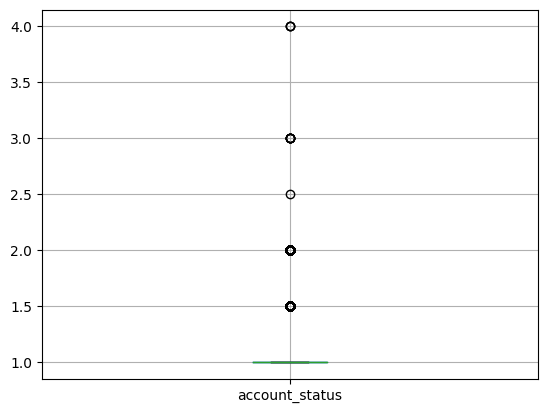

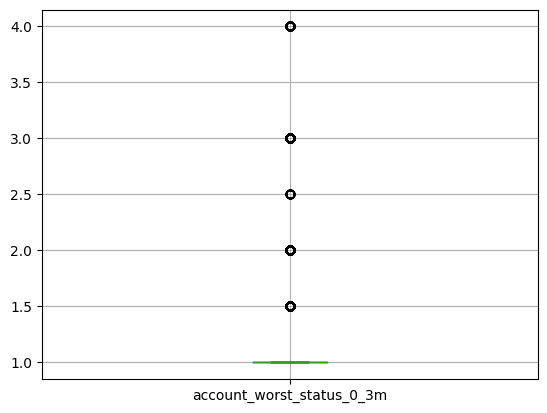

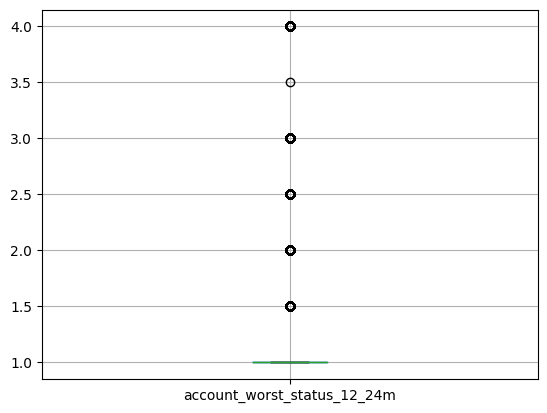

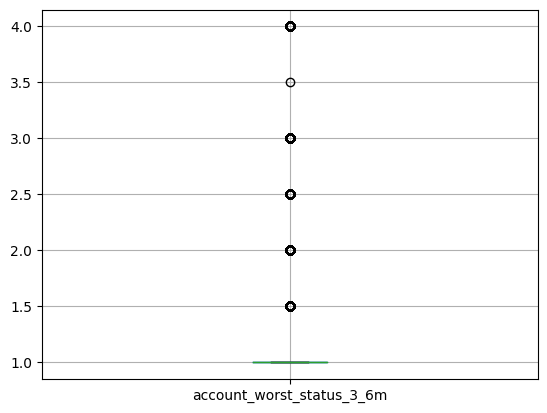

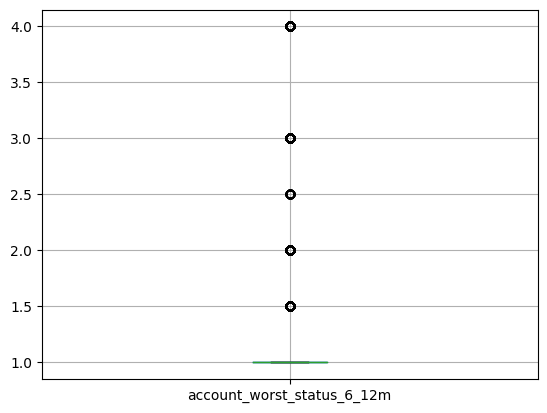

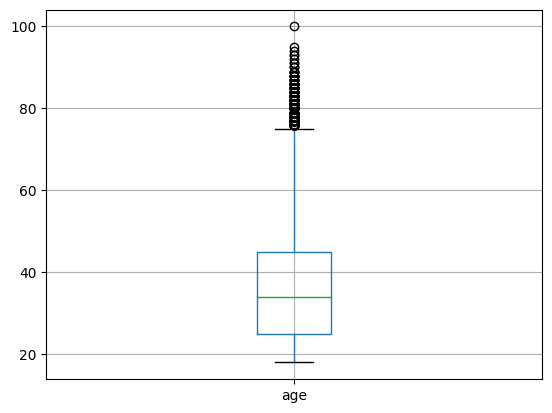

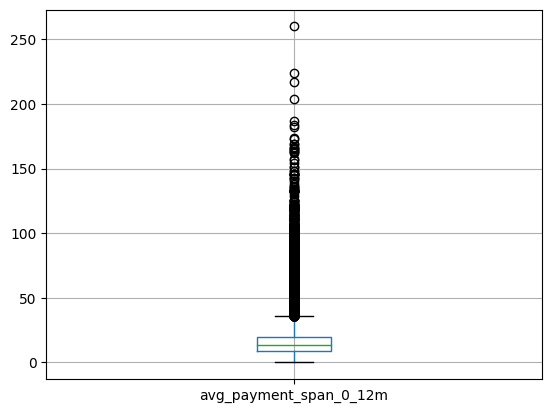

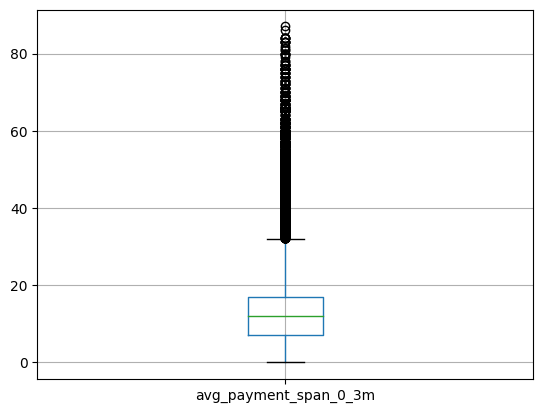

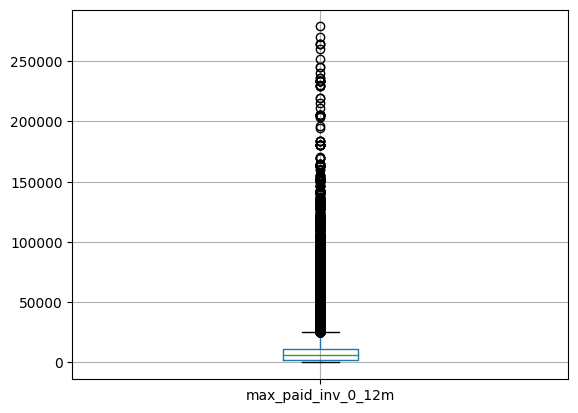

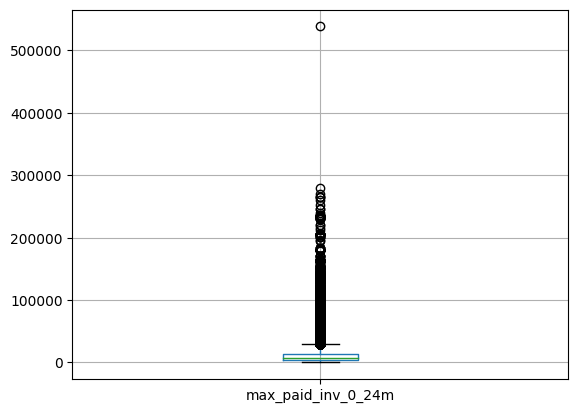

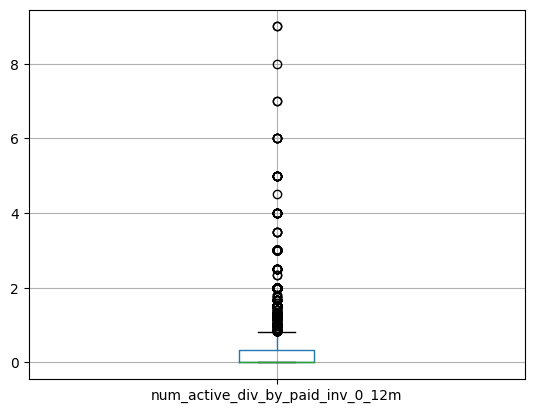

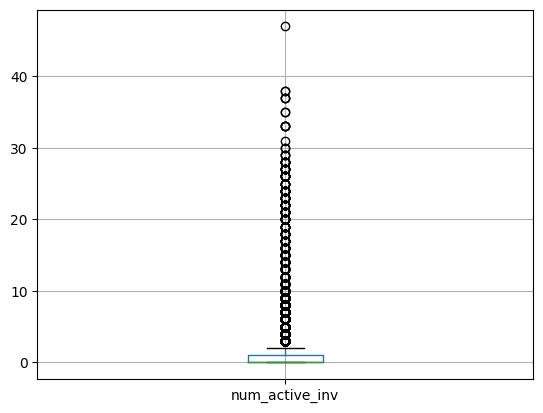

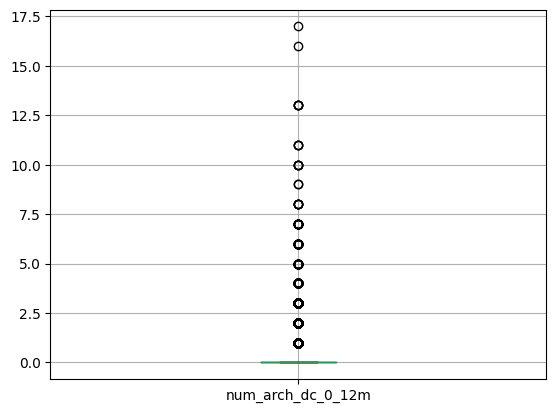

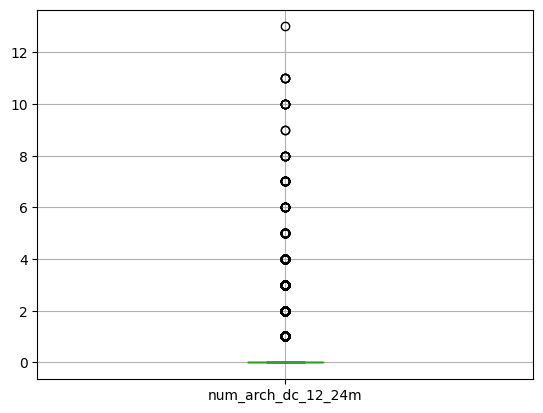

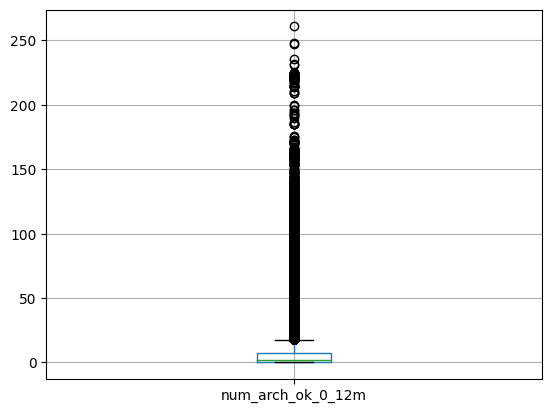

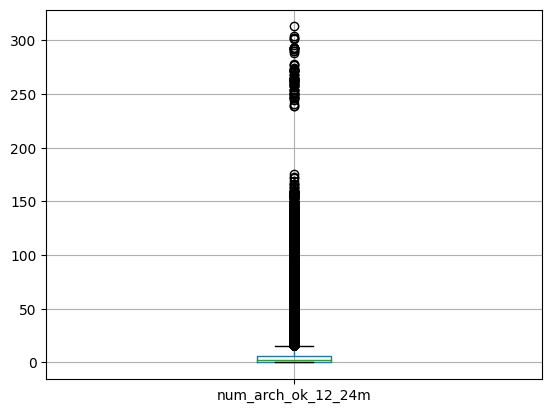

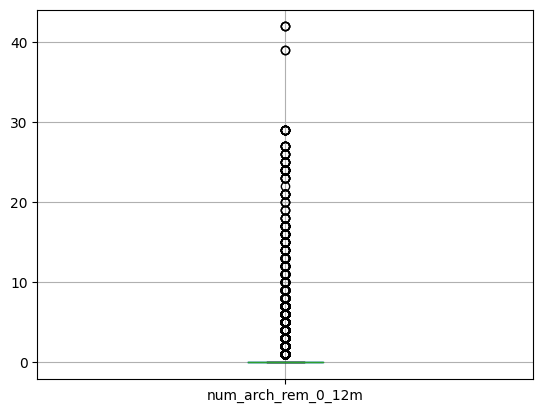

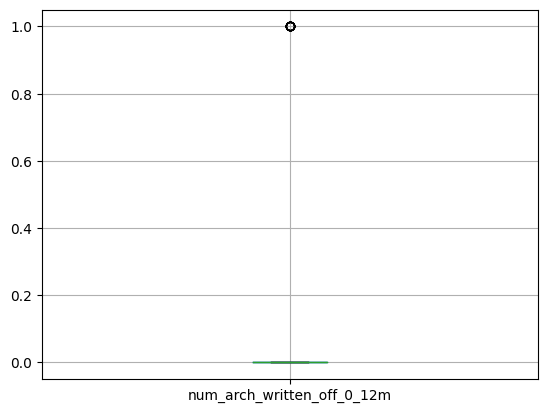

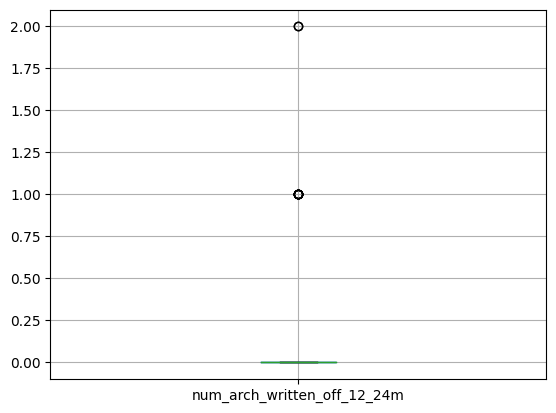

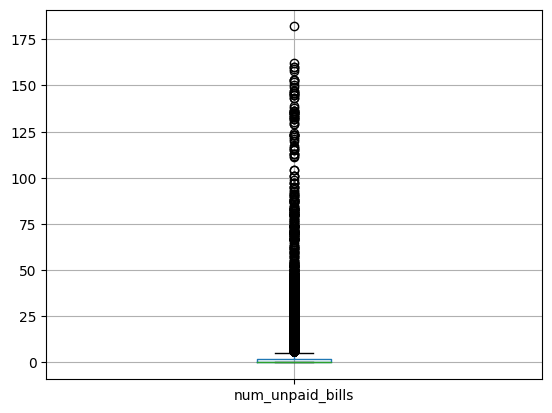

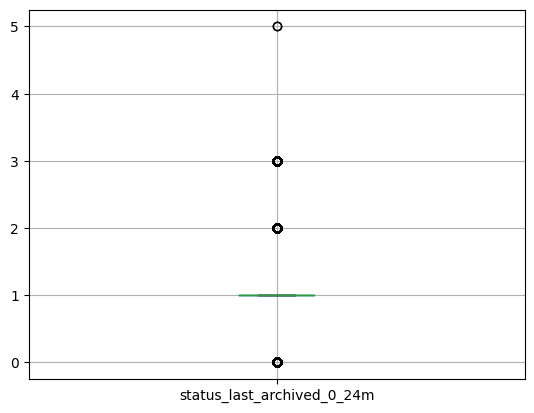

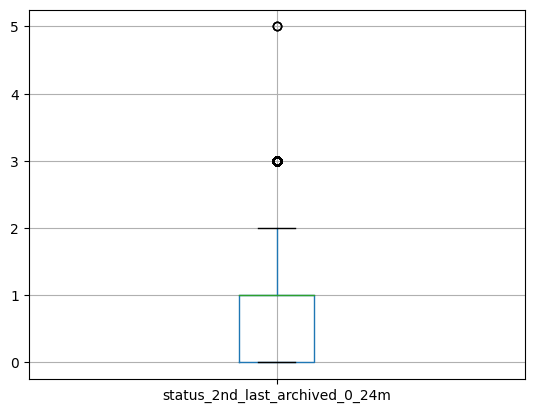

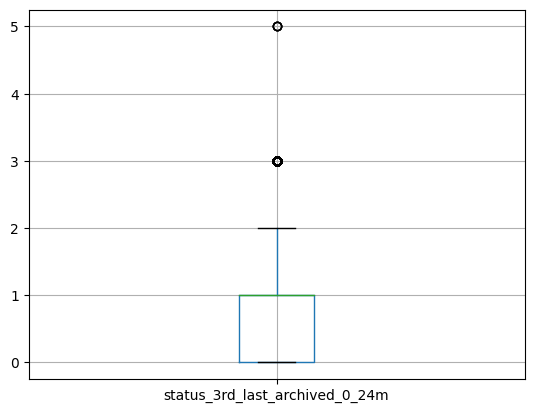

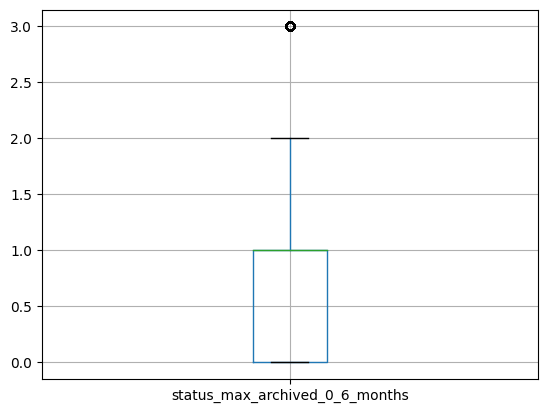

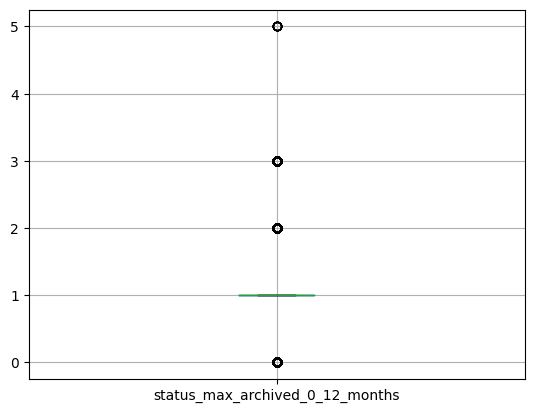

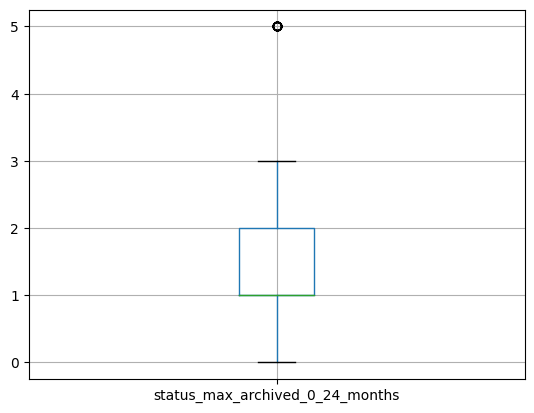

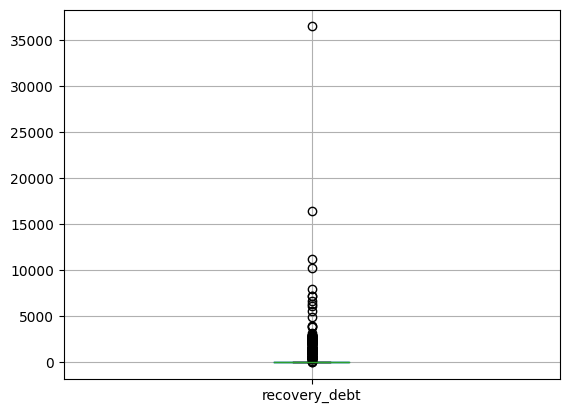

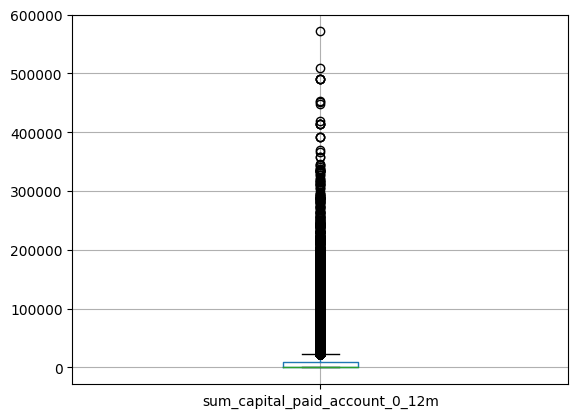

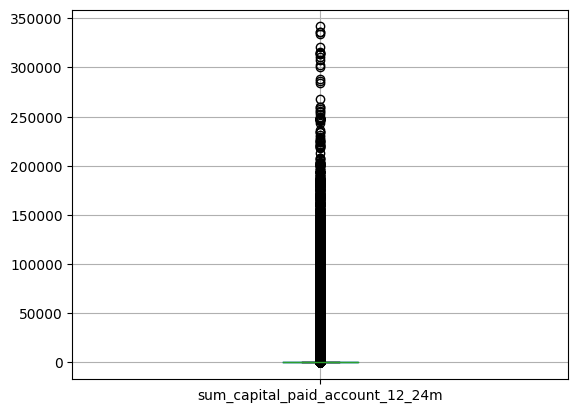

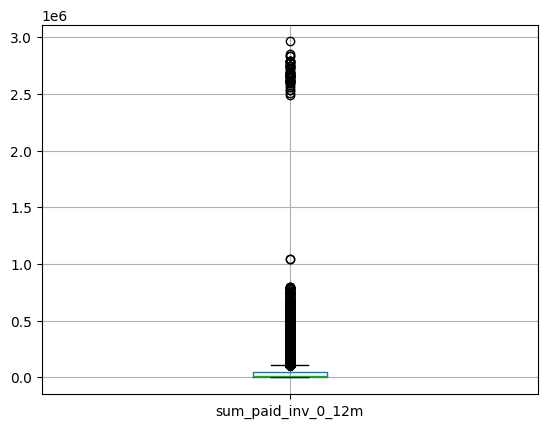

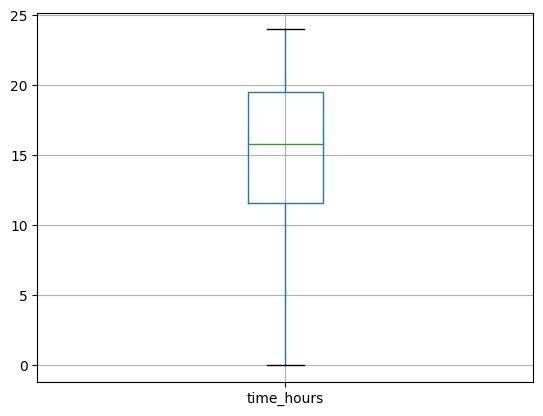

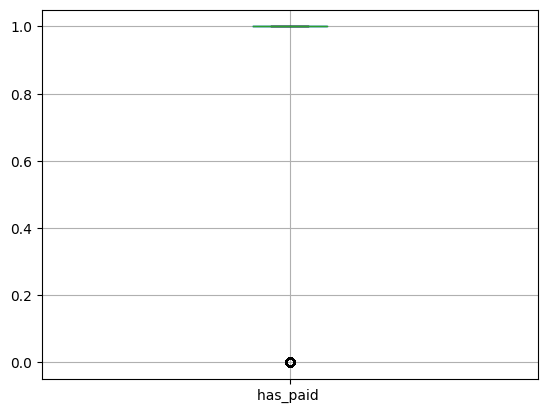

In [ ]:
# to get rid of KeyError: "None of [Index(['Name'], dtype='object')] are in the [columns]" by excluding the object dtype variables from your dataframe
df = data_clean_df.select_dtypes(exclude=['object'])

for column in df:
    plt.figure()
    df.boxplot([column])
    plt.show()


In [ ]:
import numpy as np; np.random.seed(42)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame(data = np.random.random(size=(4,4)), columns = ['A','B','C','D'])

sns.boxplot(x="variable", y="value", data=pd.melt(df))

plt.show()

### 1.4. Feature Scaling

In [ ]:
encode_cat = pd.DataFrame(cat_preprocessor.fit_transform(data_clean_df))
encode_cat.shape

/Users/emilioaguiar/.pyenv/versions/3.8.12/envs/klarna/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/emilioaguiar/.pyenv/versions/3.8.12/envs/klarna/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(99976, 78)

### 1.5. Data Balancing